## Exploration of the relation between the different circle approximation of histology and MR diffusion signal

It is conveniant to talk about axons in term of radius, implicitely assuming the cylinder model.  
Therefore, it is necessary to convert the true segmented "shapes" of histology to a radius.  
This can be done in multiple ways such as smallest inscribed circle, equivalent area circle, longuest or shortest axis circle, etc...   

For MR, the various "shapes" will gives rise to some non-rotationally symmetrical mean-squared displacement.  
Under long time regime hypothesis, these signal can be matched to equivalent radius.  
This can be done with 2D Monte-Carlo simmulations and with discrete direct approximation of MSD.

We want to get an idea of how good/bad each histology circle approximation is versus the MR equivalency which is typically the comparaison target.

In [1]:
import numpy as np
import PIL as pil
import pylab as pl
from skimage.morphology import closing
import shapely as sha

In [2]:
axon_img = pil.Image.open('/data/hu_paquette/Pictures/small_axons_inside_135px_is_5um.png')
# axon_img = pil.Image.open('/data/hu_paquette/Pictures/big_axons_inside_135px_is_5um.png')

In [3]:
tmp = np.array(axon_img)

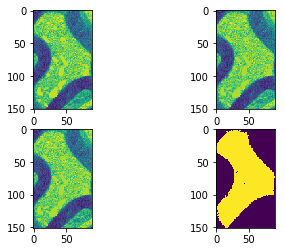

In [4]:
pl.figure()
for i in range(4):
    pl.subplot(2,2,i+1)
    pl.imshow(tmp[:,:,i])
pl.show()

In [5]:
# get clean "binary" mask
inside = tmp[:,:,3]
print('funky pixel before: {}'.format(np.prod(inside.shape) - (inside==inside.max()).sum() - (inside==inside.min()).sum()))

center = inside.min() + (inside.max() - inside.min())/2
inside[inside<=center] = inside.min()
inside[inside>center] = inside.max()
print('funky pixel after: {}'.format(np.prod(inside.shape) - (inside==inside.max()).sum() - (inside==inside.min()).sum()))


funky pixel before: 40
funky pixel after: 0


In [6]:
# element for closing morpho operation
selem = np.ones((3,3), dtype=np.bool)

In [7]:
# clean littles holes
closed = closing(inside, selem)
print('funky pixel after: {}'.format(np.prod(closed.shape) - (closed==closed.max()).sum() - (closed==closed.min()).sum()))

funky pixel after: 0


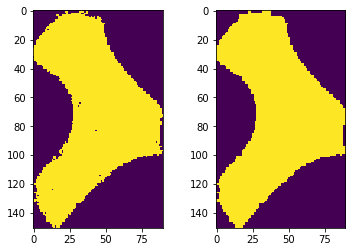

In [8]:
pl.figure()
pl.subplot(1,2,1)
pl.imshow(inside)
pl.subplot(1,2,2)
pl.imshow(closed)
pl.show()

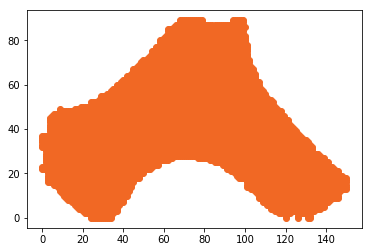

In [9]:
# convert image to 2D point for boundary definition
(x,y) = np.where(closed)

pl.figure()
pl.plot(x,y,'o', color='#f16824')
pl.show()

In [10]:
import shapely.geometry as geometry
point_collection = geometry.MultiPoint([[p[0],p[1]] for p in zip(x, y)])

In [11]:
from descartes import PolygonPatch

def plot_polygon(polygon):
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

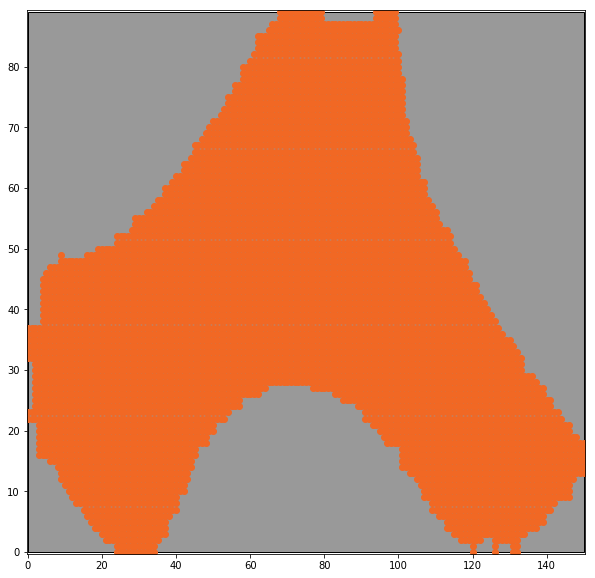

In [12]:
_ = plot_polygon(point_collection.envelope)
_ = pl.plot(x,y,'o', color='#f16824')
pl.show()

In [13]:
convex_hull_polygon = point_collection.convex_hull

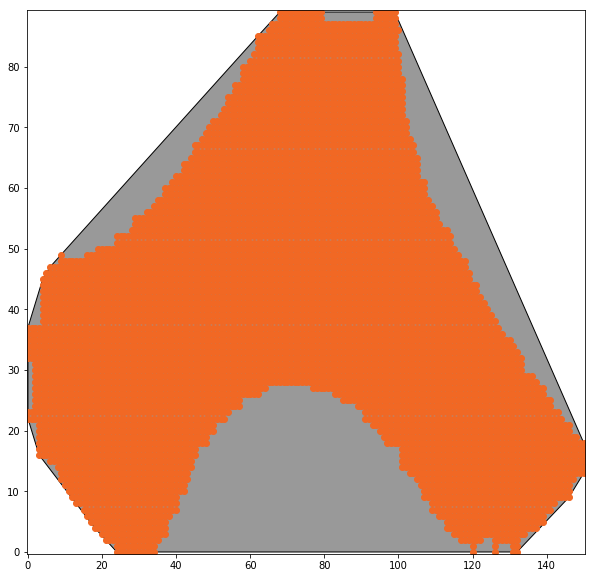

In [14]:
_ = plot_polygon(convex_hull_polygon)
_ = pl.plot(x,y,'o', color='#f16824')
pl.show()

In [15]:
# big thanks to http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math

def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return 
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
        
    coords = np.array(points)
    if coords.shape[0] < coords.shape[1]:
        coords = coords.T
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    
    return cascaded_union(triangles), edge_points

In [16]:
concave_hull, edge_points = alpha_shape([x,y], alpha=0.5)

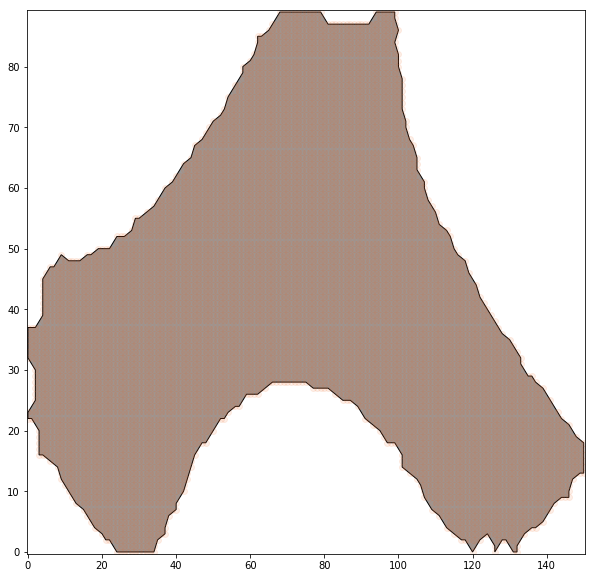

In [17]:
_ = plot_polygon(concave_hull)
_ = pl.plot(x,y,'o', color='#f16824', alpha=0.1)
pl.show()

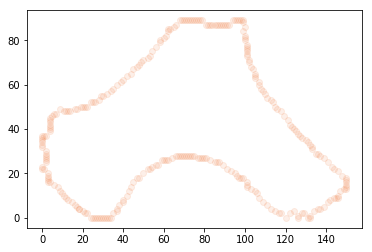

In [18]:
t = np.array(concave_hull.boundary.coords)
_ = pl.plot(t[:,0], t[:,1],'o', color='#f16824', alpha=0.1)

In [19]:
# function called .contains() that checks if a polygon contains a point
spts_out = geometry.Point(3.0000, 20.0)
spts_in  = geometry.Point(3.0001, 20.0)
print(concave_hull.contains(spts_out))
print(concave_hull.contains(spts_in))

False
True


In [20]:
# function called .within() that checks if a point is within a polygon
print(spts_out.within(concave_hull))
print(spts_in.within(concave_hull))

False
True


In [21]:
print(concave_hull.area)

7064.5


In [22]:
from scipy.interpolate import splprep, splev

tck, u = splprep(t.T, u=None, s=0.0, per=1) 
u_new = np.linspace(u.min(), u.max(), 1000)
x_new, y_new = splev(u_new, tck, der=0)

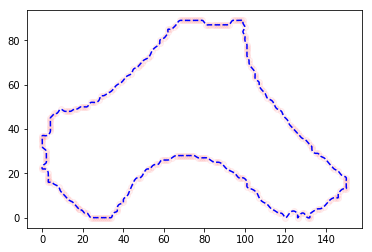

In [23]:
pl.figure()
pl.plot(t[:,0], t[:,1], 'ro', alpha=0.05)
pl.plot(x_new, y_new, 'b--')
pl.show()

In [24]:
from intersect import intersection

In [25]:
(cx, cy) = (70,10)
m = 0

In [26]:
# y = mx + b
b = cy - m*cx
xx = np.linspace(cx-90, cx+90, 100, endpoint=True)
yy = m*xx+b

In [27]:
xint, yint = intersection(t[:,0], t[:,1], xx, yy)

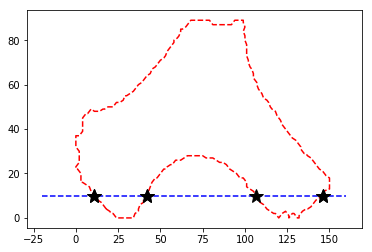

In [28]:
pl.figure()
pl.plot(t[:,0], t[:,1], 'r--')
pl.plot(xx, yy, 'b--')
pl.plot(xint, yint, '*k', markersize=15)
pl.show()

In [29]:
# TODO for grid MSD
# split line intersect in forward/backward to take max dist
# add tiny function to set line lenght from envelope?
# check center point isInside from polygon?
# angle to m

In [30]:
# TODO for simple stuff
# area, perimeter etc
# radius helper func

In [31]:
# length from points
def len_curve_pts(pts):
    # pts are Nx2
    # Assumes pts[0] is connected to pts[-1]
    tmp = pts[1:] - pts[:-1]
    dists = np.sqrt(tmp[:,0]**2+tmp[:,1]**2)
    # add last pts
    return dists.sum() + np.sqrt((pts[-1,0]-pts[0,0])**2+(pts[-1,1]-pts[0,1])**2)

In [32]:
len_t = len_curve_pts(t)
t_new = np.concatenate((x_new[:,None], y_new[:,None]), axis=1)
len_t_new = len_curve_pts(t_new)

In [33]:
print(len_t)
print(concave_hull.boundary.length)
print(len_t_new)

439.79425991589943
439.79425991589966
444.8575533957391


# MSD "ray" computation prototype

In [34]:
# get rough size limit for center sampling and line bounding 
x_min, y_min, x_max, y_max = point_collection.envelope.bounds

In [35]:
# grid the square at fixed resolution
resolution = 1 # pixel
x_range = np.arange(x_min-1, x_max+2, resolution)
y_range = np.arange(y_min-1, y_max+2, resolution)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
# convert to list of shapely points
all_pts = [geometry.Point(x, y) for (x,y) in zip(X_grid.ravel(), Y_grid.ravel())]
# find all points inside the hull
valid_center = []
for pts in all_pts:
    if pts.within(concave_hull):
        valid_center.append(pts)

In [36]:
# test to define 1 "ray"
i = 400
# grab valid center
cx = valid_center[i].x
cy = valid_center[i].y
# define m from theta
theta = 30 # degrees from y=const and starting ++ quarant
m = np.tan(np.pi*theta/180)
# y = mx + b
b = cy - m*cx

In [37]:
# intersection both side

# one side
xx_1 = np.linspace(cx, x_max, 100, endpoint=True)
yy_1 = m*xx_1+b
xint1, yint1 = intersection(t[:,0], t[:,1], xx_1, yy_1)

# other side
xx_2 = np.linspace(x_min, cx, 100, endpoint=True)
yy_2 = m*xx_2+b
xint2, yint2 = intersection(t[:,0], t[:,1], xx_2, yy_2)

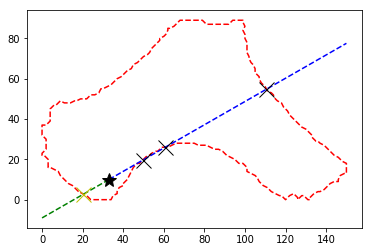

In [38]:
pl.figure()
pl.plot(t[:,0], t[:,1], 'r--')
pl.plot(xx_1, yy_1, 'b--')
pl.plot(xint1, yint1, 'xk', markersize=15)
pl.plot(xx_2, yy_2, 'g--')
pl.plot(xint2, yint2, 'xy', markersize=15)
pl.plot(cx, cy, '*k--', markersize=15)
pl.show()

In [39]:
indx1 = np.argmax((xint1 - cx)**2 + (yint1 - cy)**2)
pts_max1 = np.array([xint1[indx1], yint1[indx1]])

indx2 = np.argmax((xint2 - cx)**2 + (yint2 - cy)**2)
pts_max2 = np.array([xint2[indx2], yint2[indx2]])

In [40]:
# compute distance of all pair of center
all_distances = np.zeros((len(valid_center), len(valid_center), 2))

for i in range(len(valid_center)-1):
    for j in range(i+1, len(valid_center)):
        all_distances[i,j,0] = valid_center[i].x - valid_center[j].x
        all_distances[i,j,1] = valid_center[i].y - valid_center[j].y

In [41]:
# upper triangle without diagonal
all_distances_triu = (all_distances)[np.triu_indices(len(valid_center), k=1)]

In [42]:
# all orientations (eery degree)
theta = np.linspace(0, 179, 180, endpoint=True)*(np.pi/180)
all_gradients = np.zeros([2,len(theta)])
all_gradients[0] = np.cos(theta)
all_gradients[1] = np.sin(theta)


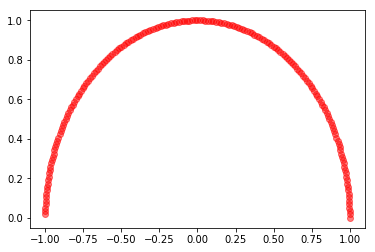

In [43]:
pl.figure()
pl.plot(all_gradients[0], all_gradients[1], 'ro', alpha=0.5)
pl.show()

In [44]:
all_distances_triu.shape

(23870595, 2)

In [45]:
# memory buster
# all_distance_gradient = all_distances_triu.dot(all_gradients)

In [46]:
px2um = (5/135)

In [47]:
cumul_sq_dist = np.zeros(180)
# for a SMALL subset of positions pair,
chunk = 100000
curr = 0
for i in range(int(np.ceil(all_distances_triu.shape[0]/chunk))):
    # compute projection of displacement onto all gradients
    test = all_distances_triu[curr:curr+chunk].dot(all_gradients)
    curr += chunk
    # convert from pixel to um and square them
    # 135 px is 5 um
    test = (test*px2um)**2
    # add to the cumul
    cumul_sq_dist += test.sum(0)

In [48]:
msds = cumul_sq_dist/all_distances_triu.shape[0]

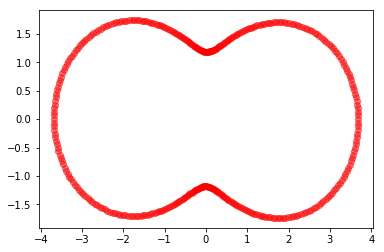

In [49]:
pl.figure()
pl.plot(msds*all_gradients[0], msds*all_gradients[1], 'ro', alpha=0.5)
pl.plot(-msds*all_gradients[0], -msds*all_gradients[1], 'ro', alpha=0.5)
pl.show()

In [50]:
msds.min()

1.182927209469253

In [51]:
msds.max()

3.6844840149697045

In [52]:
def diam2MSD(diam):
    # for circle, in long time limit
    # MSD = R^2/2 = d^2/8
    return diam**2/8

In [53]:
def MSD2diam(msd):
    # for circle, in long time limit
    # diam = sqrt(8*MSD)
    return np.sqrt(8*msd)

In [54]:
list_method_name = []
list_method_res = []

In [55]:
directional_equivalent_diameter = MSD2diam(msds)

In [56]:
directional_equivalent_diameter.mean()

4.334458008573909

In [57]:
directional_equivalent_diameter.min()

3.076266840791615

In [58]:
directional_equivalent_diameter.max()

5.429168639834062

In [59]:
directional_equivalent_diameter.std()

0.8259047582290875

In [60]:
ddata = directional_equivalent_diameter.copy()
print('[{:.4f}, {:.4f}]  {:.4f} ({:.4f})'.format(ddata.min(), ddata.max(), ddata.mean(), ddata.std()))

[3.0763, 5.4292]  4.3345 (0.8259)


In [61]:
def perimeter2diam(peri):
    # Perimeter = pi diam
    return peri/np.pi

In [62]:
diameter_perimeterMethod = perimeter2diam(px2um*concave_hull.boundary.length)
diameter_perimeterMethod
list_method_name.append('perimeterMethod')
list_method_res.append(diameter_perimeterMethod)

In [63]:
def area2diam(area):
    # area = pi r^2 = pi diam^2 / 4
    return np.sqrt((4*area)/np.pi)

In [64]:
diameter_areaMethod = area2diam(concave_hull.area*px2um**2)
diameter_areaMethod
list_method_name.append('areaMethod')
list_method_res.append(diameter_areaMethod)

In [65]:
# biggest inscribed circle
from scipy.spatial import Voronoi, voronoi_plot_2d

# using boundary points
vor = Voronoi(t)
# # using subsampled from fited curve to boundary points
# u_new = np.linspace(u.min(), u.max(), 100)
# x_new, y_new = splev(u_new, tck, der=0)
# t_new = np.concatenate((x_new[:,None], y_new[:,None]), axis=1)
# vor = Voronoi(t_new)

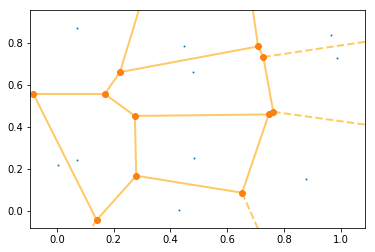

In [66]:
n=10
fig = voronoi_plot_2d(Voronoi(np.random.random((n,2))), show_vertices=True, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)

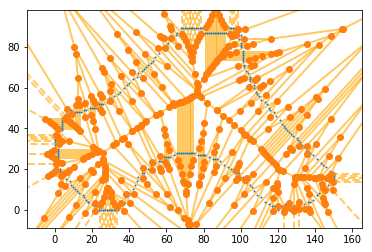

In [67]:
fig = voronoi_plot_2d(vor, show_vertices=True, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)
pl.show()

In [68]:
def closest_node(pt, pts_list):
    dist = np.linalg.norm(pts_list - pt, axis=1)
    # idx, pts, dist
    tmp = np.argmin(dist)
    return tmp, pts_list[tmp], dist[tmp]

In [69]:
# find inscribed circle    
max_d = 0
max_v = None
for v in vor.vertices:
    spts  = geometry.Point(v[0], v[1])
    if concave_hull.contains(spts):
        _, _, d = closest_node(v, t)
        if d > max_d:
            max_d = d
            max_v = v

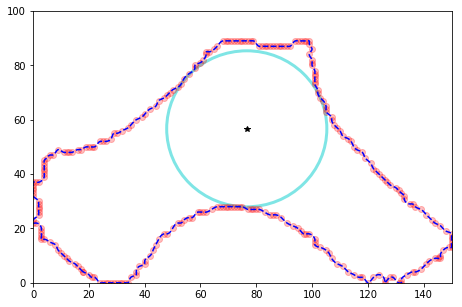

In [70]:
fig, ax = pl.subplots(figsize=(7.5,5))
pl.plot(t[:,0], t[:,1], 'ro', alpha=0.25)
pl.plot(x_new, y_new, 'b--')
pl.plot(max_v[0], max_v[1], '*k')
circle = pl.Circle(max_v, radius=max_d, facecolor='none', edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)
pl.xlim(0,150)
pl.ylim(0,100)
pl.show()

In [71]:
diameter_inscribedMethod = 2*max_d*px2um
diameter_inscribedMethod
list_method_name.append('inscribedMethod')
list_method_res.append(diameter_inscribedMethod)

In [72]:
# smallest encompassing circle, stolen from pointpats
import copy
from scipy.spatial import ConvexHull

def minimum_bounding_circle(points):
    points = hull(points)
    if not_clockwise(points):
        points = points[::-1]
        if not_clockwise(points):
            raise Exception("Points are neither clockwise nor counterclockwise")
    POINTS = copy.deepcopy(points)
    removed = []
    i = 0
    circ = _skyum_lists(POINTS)[0]
    return (circ[1], circ[2]), circ[0]

def hull(points):
    points = np.asarray(points)
    h = ConvexHull(points)
    return points[h.vertices]

def is_clockwise(vertices):
    if len(vertices) < 3:
        return True
    area = 0.0
    ax, ay = vertices[0]
    for bx, by in vertices[1:]:
        area += ax * by - ay * bx
        ax, ay = bx, by
    bx, by = vertices[0]
    area += ax * by - ay * bx
    return area < 0.0
    
not_clockwise = lambda x: not is_clockwise(x)


def _skyum_lists(points):
    points = points.tolist()
    removed = []
    i = 0
    while True:
        angles = [_angle(_prec(p, points), p, _succ(p, points),) for p in points]
        circles = [_circle(_prec(p, points), p, _succ(p, points),) for p in points]
        radii = [c[0] for c in circles]
        lexord = np.lexsort((radii, angles))  # confusing as hell defaults...
        lexmax = lexord[-1]
        candidate = (
            _prec(points[lexmax], points),
            points[lexmax],
            _succ(points[lexmax], points),
        )
        if angles[lexmax] <= (np.pi / 2.0):
            # print("Constrained by points: {}".format(candidate))
            return _circle(*candidate), points, removed, candidate
        else:
            try:
                removed.append((points.pop(lexmax), i))
            except IndexError:
                raise Exception("Construction of Minimum Bounding Circle failed!")
        i += 1


def _succ(p, l):
    pos = l.index(p)
    if pos + 1 >= len(l):
        return l[0]
    else:
        return l[pos + 1]

def _prec(p, l):
    pos = l.index(p)
    if pos - 1 < 0:
        return l[-1]
    else:
        return l[pos - 1]

def _angle(p, q, r):
    pq = np.array(p) - np.array(q)
    rq = np.array(r) - np.array(q)
    magnitudes = np.linalg.norm(pq) * np.linalg.norm(rq)
    return np.abs(np.arccos(np.dot(pq, rq) / magnitudes))

def _euclidean_distance(px, py, qx, qy):
    return np.sqrt((px - qx) ** 2 + (py - qy) ** 2)

def _circle(p, q, r, dmetric=_euclidean_distance):
    px, py = p
    qx, qy = q
    rx, ry = r
    angle = np.abs(_angle(p, q, r))
    if np.abs(angle - np.pi) < 1e-5:  # angle is pi
        radius = dmetric(px, py, rx, ry) / 2.0
        center_x = (px + rx) / 2.0
        center_y = (py + ry) / 2.0
    elif np.abs(angle) < 1e-5:  # angle is zero
        radius = dmetric(px, py, qx, qy) / 2.0
        center_x = (px + qx) / 2.0
        center_y = (py + qy) / 2.0
    else:
        D = 2 * (px * (qy - ry) + qx * (ry - py) + rx * (py - qy))
        center_x = (
            (px ** 2 + py ** 2) * (qy - ry)
            + (qx ** 2 + qy ** 2) * (ry - py)
            + (rx ** 2 + ry ** 2) * (py - qy)
        ) / float(D)
        center_y = (
            (px ** 2 + py ** 2) * (rx - qx)
            + (qx ** 2 + qy ** 2) * (px - rx)
            + (rx ** 2 + ry ** 2) * (qx - px)
        ) / float(D)
        radius = dmetric(center_x, center_y, px, py)
    return radius, center_x, center_y

In [73]:
center, radius = minimum_bounding_circle(t)

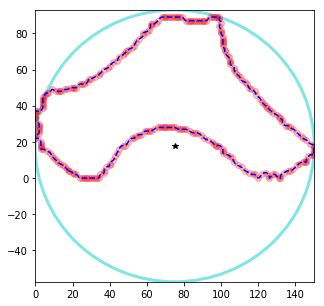

In [74]:
fig, ax = pl.subplots(figsize=(5,5))
pl.plot(t[:,0], t[:,1], 'ro', alpha=0.25)
pl.plot(x_new, y_new, 'b--')
pl.plot(center[0], center[1], '*k')
circle = pl.Circle(center, radius=radius, facecolor='none', edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)
pl.xlim(center[0]-radius,center[0]+radius)
pl.ylim(center[1]-radius,center[1]+radius)
pl.show()

In [75]:
diameter_enclosingMethod = 2*radius*px2um
diameter_enclosingMethod
list_method_name.append('enclosingMethod')
list_method_res.append(diameter_enclosingMethod)

In [76]:
# fit ellipse for long and short axis
U, S, V = np.linalg.svd((t - t.mean(axis=0)).T)

tt = np.linspace(0, 2*np.pi, 1000)
circle = np.stack((np.cos(tt), np.sin(tt)))    # unit circle
transform = np.sqrt(2/t.shape[0]) * U.dot(np.diag(S))   # transformation matrix
fit = transform.dot(circle) + np.array([[t[:,0].mean()], [t[:,1].mean()]])

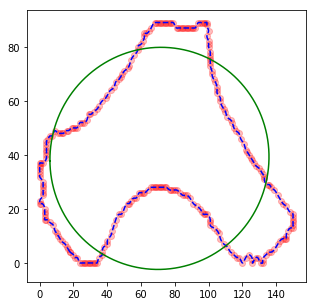

In [77]:
fig, ax = pl.subplots(figsize=(5,5))
pl.plot(t[:,0], t[:,1], 'ro', alpha=0.25)
pl.plot(x_new, y_new, 'b--')
pl.plot(fit[0, :], fit[1, :], 'g')
pl.show()

In [78]:
minL = np.linalg.norm(transform.dot(circle), axis=0).min()

In [79]:
maxL = np.linalg.norm(transform.dot(circle), axis=0).max()

In [80]:
(longaxis, shortaxis) = 2*S*np.sqrt(2/t.shape[0])

In [81]:
diameter_longAxisMethod = longaxis*px2um
diameter_longAxisMethod
list_method_name.append('longAxisMethod')
list_method_res.append(diameter_longAxisMethod)

In [82]:
diameter_shortAxisMethod = shortaxis*px2um
diameter_shortAxisMethod
list_method_name.append('shortAxisMethod')
list_method_res.append(diameter_shortAxisMethod)

In [83]:
# list_method_name = []
# list_method_res = []

# # list_method_name.append('perimeterMethod')
# list_method_name.append('perimeter')
# list_method_res.append(diameter_perimeterMethod)

# # list_method_name.append('areaMethod')
# list_method_name.append('area')
# list_method_res.append(diameter_areaMethod)

# # list_method_name.append('inscribedMethod')
# list_method_name.append('inscribed')
# list_method_res.append(diameter_inscribedMethod)

# # list_method_name.append('enclosingMethod')
# list_method_name.append('enclosing')
# list_method_res.append(diameter_enclosingMethod)

# # list_method_name.append('longAxisMethod')
# list_method_name.append('long Axis')
# list_method_res.append(diameter_longAxisMethod)

# # list_method_name.append('shortAxisMethod')
# list_method_name.append('short Axis')
# list_method_res.append(diameter_shortAxisMethod)

In [84]:
# Discrete 2D MC
# D = 0.66 um^2/ms
# dx = 5/135 um
# total = 100 ms
msds_mc = np.load('/data/hu_paquette/work/notebooks/small_axons_inside_msds.npy')

In [85]:
directional_equivalent_diameter = MSD2diam(msds_mc)
equivalent_diameter = np.concatenate((directional_equivalent_diameter[:,None], directional_equivalent_diameter[:,None]), axis=1)
equivalent_name = ['Discrete', 'MC']

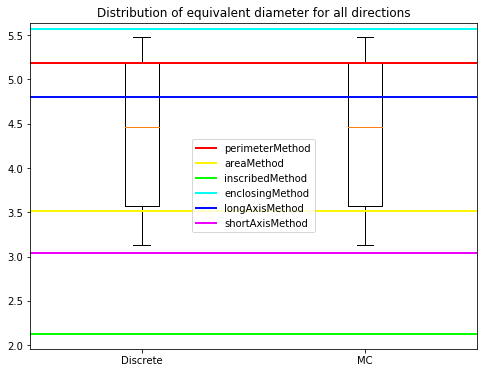

In [86]:
mycolormap = pl.cm.hsv
_colors = (mycolormap(i) for i in np.linspace(0, 1, len(list_method_name)+1))
pl.figure(figsize=(8,6))
# pl.boxplot(directional_equivalent_diameter)
pl.boxplot(equivalent_diameter)
pl.xticks(range(1,equivalent_diameter.shape[1]+1), equivalent_name)
for i in range(len(list_method_name)):
    pl.axhline(list_method_res[i], label=list_method_name[i],color=next(_colors), linewidth=2)
pl.legend()
pl.title('Distribution of equivalent diameter for all directions')
pl.show()

In [87]:
# load msd time curves for a few angles
timestamp = np.load('/data/hu_paquette/work/notebooks/small_axons_timestamp.npy')

wanted_angle = [0, 45, 90, 135]
curves = np.load('/data/hu_paquette/work/notebooks/small_axons_curves_{}.npy'.format(len(wanted_angle)))

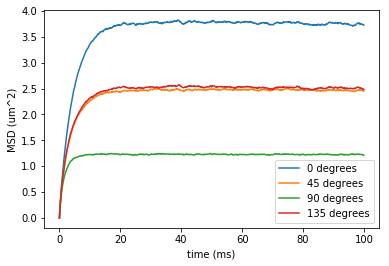

In [88]:
pl.figure()
for i in range(len(wanted_angle)):
    pl.plot(timestamp, curves[i], label='{} degrees'.format(wanted_angle[i]))
pl.xlabel('time (ms)')
pl.ylabel('MSD (um^2)')
pl.legend()
pl.show()

In [89]:
# theta = np.linspace(0, 359, 360, endpoint=True)*(np.pi/180)
# ms = np.tan(theta)
# bs = cy - ms*cx
# # filter for 90 degree 